# NPZD slab-ocean model

The classic Nutrient-Phytoplankton-Zooplankton-Detritus (NPZD) model is embedded in a slab-ocean physical setting (e.g. Evans et al . 1985, Fasham et al. 1990). “Slab” refers to a simplified zero-dimensional model of the oceanic upper mixed layer, which depth varies seasonally. This model structure provides an efficient physical setting for more complicated ecosystem descriptions and is used for both research and teaching purposes. This application is inspired by the EMPOWER model, as presented by Anderson et al. 2015. See below for a schematic of the model structure.

In the model, phytoplankton growth is driven by temperature, light, and nutrients. Phytoplankton are consumed by zooplankton, which are in turn subject to a higher order mortality (reflecting predation by higher trophic levels). Phytoplankton and zooplankton mortality and grazing by-products fuel a detrital pool that is remineralized in the upper ocean. Changes in the depth of the upper mixed layer have effects on all components. Nutrients are exchanged between the upper ocean and deep ocean across the mixed layer boundary. Fractions of phytoplankton, zooplankton, and detritus are lost due to mixing, with detritus additionally sinking out of the mixed layer at a constant rate.

Many NPZD-type models have been published over the years, with a variety of formulations for the functional responses of the ecosystem components. Anderson et al. showcase multiple alternative formulations, particularly focusing on the treatment of light in the model. We partially follow their analysis by considering two different light-attenuation algorithms in our modular implementation with the XSO Framework.

> Anderson, T. R., Gentleman, W. C., & Yool, A. (2015). EMPOWER-1.0: an efficient model of planktonic ecosystems written in R. Geoscientific Model Development, 8(7), 2231-2262.
[Link to Article at GMD](https://gmd.copernicus.org/articles/8/2231/2015/)

## System of equations

The following is a simplied overview over the system of equations. Please reference the original publication, or the current publication that presents XSO and Phydra, for a detailed description.

$$
%Nutrient
\begin{equation}
    \frac{d N}{d t} = 
    K (N_0 - N) % Nutrient mixing
    + \beta(1 - \epsilon)(G_P + G_D) % Unassimilated grazing by Z
    + m_D \ D % Remineralisation of D
    - \mu_{P} \ P % Phytoplankton gains
\end{equation}
$$

$$
%PHYTOPLANKTON
\begin{equation}
    \frac{d P}{d t} =
    \mu_{P} \ P  % Phytoplankton gains
    - m_P \ P % Linear mortality
    - m_{P2} \ P^2 % Quadratic mortality
    - G_P % Z grazing
    - K \ P % Phytoplankton mixing
\end{equation}
$$

$$
%ZOOPLANKTON
\begin{equation}
    \frac{d Z}{d t} =
    \beta \ \epsilon(G_P + G_D) % Assimilated grazing
    - m_Z \ Z % Linear mortality
    - m_{Z2} \ Z^2 % Quadratic mortality
    - K \ Z % Zooplankton mixing
\end{equation}
$$

$$
%DETRITUS
\begin{equation}
    \frac{d D}{d t} = 
    m_P \ P % Linear mortality
    + m_{P2} \ P^2 % Quadratic mortality
    + m_Z \ Z % Linear mortality
    + (1 - \beta)(G_P + G_D) % Unassimilated grazing by Z
    - G_D % Z grazing on D
    - m_D \ D % Remineralisation of D
    - K \ D % Mixing of D
    - \frac{v_D}{H} \ D % Sinking of D
\end{equation}
$$

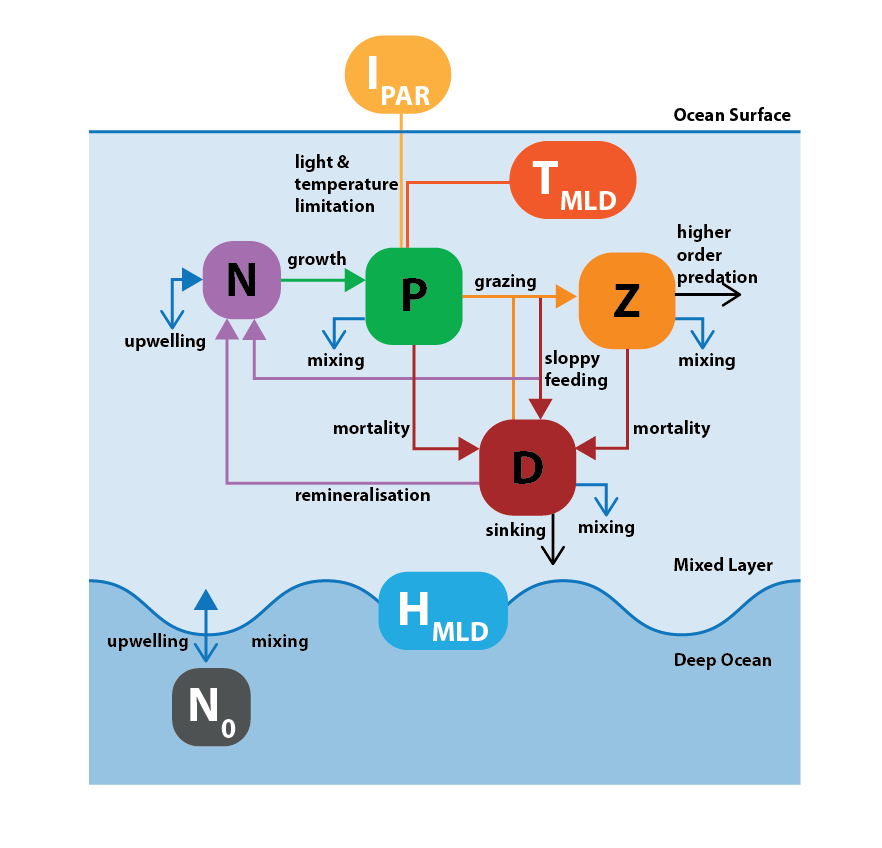

In [20]:
from IPython.display import Image
Image(filename=('images/02_schematics_NPZDSlab.png'), width=700)

In [21]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import xso

# The model object

In [22]:
# allow relative import of local directory
import sys
sys.path.append('..')

from phydra.models import NPZDSlabOcean

In [23]:
# We can find out more about the model object by simply printing it to the console:
print(NPZDSlabOcean)

<xsimlab.Model (24 processes, 64 inputs)>
Core
    solver_type              [in] solver type to use for model
Time
    time_input               [in] ('time',) sequence of time for wh...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Zooplankton
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Detritus
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Irradiance
    I0_label                 [in] label / calculated irradiance for...
    station                  [in] parameter / name of station, opti...
Forcings
    MLD_label                [in] label / Empower MLD Forcing
    MLDder

Model structure is visualized in the picture below:

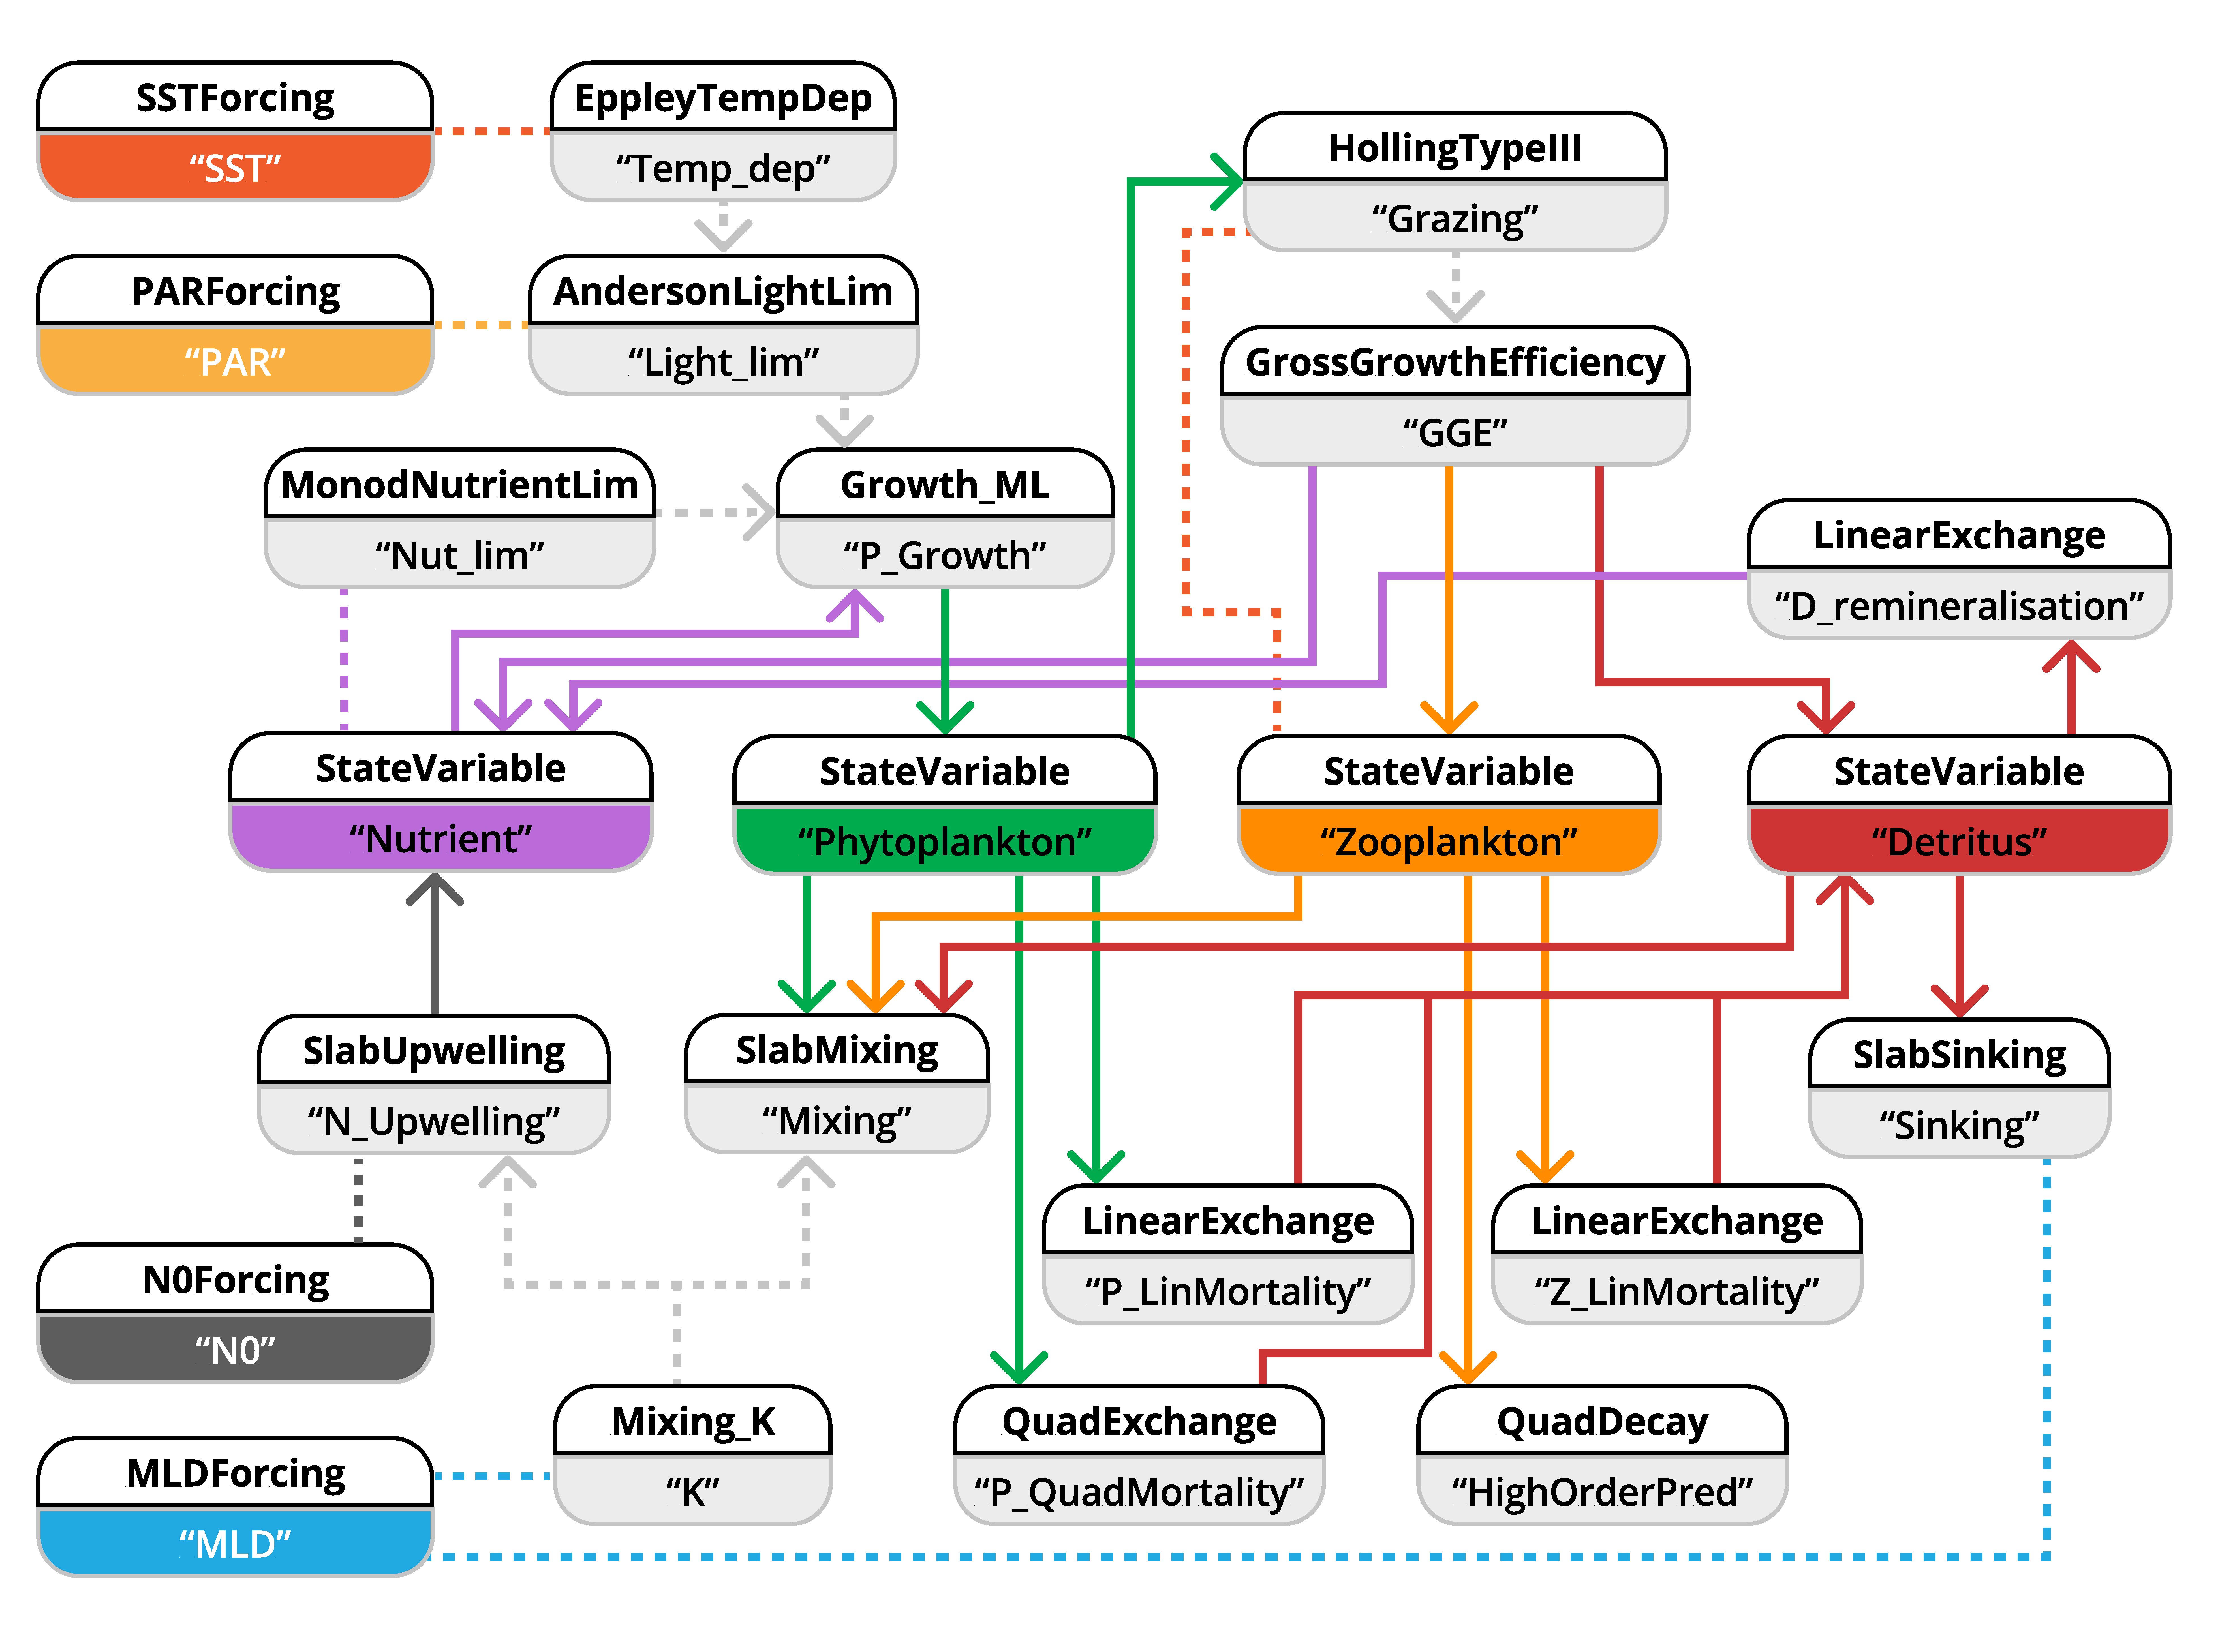

In [24]:
Image(filename=('images/02_code_NPZDSlab.png'), width=700)

# The model setup

Following Anderson et al. 2015, we compare model performance in four locations representing named ocean stations: 

- BIOTRANS
- India
- Papa
- KERFIX

We present the parameters in the table below, which were optimized for the specific locations by Anderson et al. Two of the stations are located in the temperate North Atlantic, BIOTRANS (47°N, 20°W) and India (60°N, 20°W), both of which exhibit a characteristic spring bloom of phytoplankton, followed by a low nutrient phase during summer. The other two stations, Papa in the North Pacific (50°N, 145°W) and KERFIX in the Southern Ocean (50°40'S, 68°25'E), represent High-Nutrient-Low-Chlorophyll (HNLC) environments with a much less pronounced seasonal cycle.

## Table of parameters

| Description | Parameter | BIOTRANS | India | Papa | KERFIX | Units |
| --- | --- | --- | --- | --- | --- | --- |
| Max. rate of photosynthesis at 0 °C| $V_P^{max}(0)$ | 2.5 | 2.5 | 1.25 | 1.25 | g C $(g Chl)^{-1}$ $h^{-1}$ |
| Initial slope of P-I curve | $\alpha$ | 0.15 | 0.15 | 0.075 | 0.075 | g C $(g Chl)^{-1}$ $h^{-1}$ $(W m^{-2})^{-1}$ |
| Half-saturation constant for N uptake | $k_N$ | 0.85  | 0.85  | 0.85  | 0.85 | µM N |
| Linear P mortality | $m_P$ | 0.015 | 0.015 | 0.015 | 0.015  | $d^{−1}$ |
| Quadratic P mortality | $m_{P2}$ | 0.025 | 0.025 | 0.025 | 0.025 | $(µM  N)^{-1}$ $d^{−1}$ |
| Z max. ingestion rate | $I_Z$ | 1.0 | 1.0 | 1.25 | 2.0 | $d^{−1}$ |
| Z half-saturation for intake | $k_Z$ | 0.6 | 0.6 | 0.6 | 0.6 | µM  N |
| Grazing preference: P | $\varphi_P$ | 0.67 | 0.67 | 0.67 | 0.67 | dimensionless|
| Grazing preference: D | $\varphi_D$ | 0.33 | 0.33 | 0.33 | 0.33 | dimensionless|
| Z absorption efficiency | $\beta_Z$ | 0.69 | 0.69 | 0.69 | 0.69 | dimensionless|
| Z net production efficiency | $k_{NZ}$ | 0.75 | 0.75 | 0.75 |  0.75 | dimensionless|
| Linear Z mortality | $m_Z$ | 0.02 | 0.0 | 0.02 | 0.02 | $d^{−1}$ |
| Quadratic Z mortality | $m_{Z2}$ | 0.34 | 0.34 | 0.34 | 0.34 | $(µM \ N)^{-1}$ $d^{−1}$  |
| D linear sinking rate | $v_D$ | 6.43 | 6.43 | 6.43 | 6.43 | m $d^{−1}$ |
| D remineralization rate | $m_D$ | 0.06 | 0.06 | 0.06 | 0.06 | $d^{−1}$ |
| Constant diffusive mixing | $\kappa$ | 0.13 | 0.13 | 0.13 | 0.13 | m  $d^{−1}$ |
| Carbon-to-Chlorophyll ratio | $\theta_{chl}$ |  75 | 75 | 75 | 75 | g C $(g Chl)^{−1}$ |



Here we are using the `batch dim` functionality of the Xarray-simlab to supply a single input dataset for all four stations.

In [25]:
num_years = 5

batch_setup = xso.setup(solver='solve_ivp', model=NPZDSlabOcean,
            time=np.arange(0,365*num_years),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':10.},
                    'Phytoplankton':{'var_label':'P','var_init':.5},
                    'Zooplankton':{'var_label':'Z','var_init':.1},
                    'Detritus':{'var_label':'D','var_init':.1},
                
                    # Mixing:
                    'K':{'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Upwelling':{'n':'N', 'n_0':'N0'},
                    'Mixing':{'vars_sink':['P','Z','D']},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Nut_lim':{'resource':'N', 'halfsat':.85},
                    'Light_lim':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'alpha':('batch', [0.15, 0.15, 0.075, 0.075]), 'CtoChl':75.},
                    'Temp_lim':{'temp':'SST', 'VpMax':('batch', [2.5, 2.5, 1.25, 1.25])},

                    # Grazing
                    'Grazing':{'resources':['P','D'], 'consumer':'Z',
                           'feed_prefs':[.67,.33],'Imax':('batch', [1., 1., 1.25, 2.]), 'kZ':.6},
                    'GGE':{'assimilated_consumer':'Z', 'egested_detritus':'D', 'excreted_nutrient':'N', 
                           'epsilon':0.75, 'beta':0.69},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.015},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.025},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':('batch', [0.02, 0., 0.02, 0.02])},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.06},

                    # Forcings
                    'Irradiance':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                  'I0_label':'I0'},
                    'Forcings':{'station':('batch', ['biotrans', 'india', 'papa', 'kerfix']), 
                                'MLD_label':'MLD', 'SST_label':'SST',
                                'MLDderiv_label':'MLDderiv', 'N0_label':'N0'},
            })

In [26]:
batch_setup

<xarray.Dataset>
Dimensions:                      (clock: 2, sinking_vars: 3, batch: 4,
                                  resources: 2, time: 1825)
Coordinates:
  * clock                        (clock) int64 0 1
Dimensions without coordinates: sinking_vars, batch, resources, time
Data variables: (12/64)
    Nutrient__var_label          <U1 'N'
    Nutrient__var_init           float64 10.0
    Phytoplankton__var_label     <U1 'P'
    Phytoplankton__var_init      float64 0.5
    Zooplankton__var_label       <U1 'Z'
    Zooplankton__var_init        float64 0.1
    ...                           ...
    Forcings__MLD_label          <U3 'MLD'
    Forcings__SST_label          <U3 'SST'
    Forcings__MLDderiv_label     <U8 'MLDderiv'
    Forcings__N0_label           <U2 'N0'
    Core__solver_type            <U9 'solve_ivp'
    Time__time_input             (time) int64 0 1 2 3 4 ... 1821 1822 1823 1824
Attributes:
    __xsimlab_output_vars__:  Nutrient__var,Phytoplankton__var,Zooplankton__v...

# Executing the model

In [27]:
from xsimlab.monitoring import ProgressBar

with ProgressBar():
    batch_out = batch_setup.xsimlab.run(model=NPZDSlabOcean, batch_dim='batch')

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

# Model output
The model output contains the model runs for all four stations, accesible via the dimension labelled `batch`. (Note, this could be any label, we simply chose the label `batch` to not confuse it with the `station` parameter for the forcing components).

In [28]:
# to store the full model output dataset you can simply use the `to_netcdf` method:
# batch_out.to_netcdf('slabnpzd_modelruns_1.nc')

In [29]:
# let's check the first station in our `batch` dimension:
print(batch_out.sel(batch=0).Forcings__station.values)

biotrans


Text(0.5, 1.0, 'biotrans')

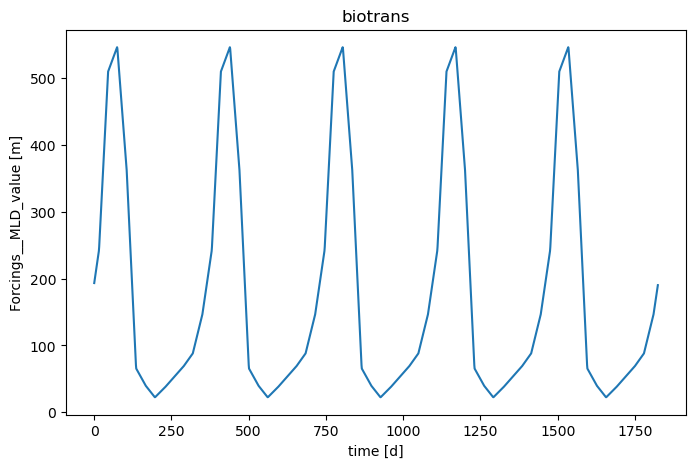

In [30]:
# we can visualize the MLD forcing that was used in the model for station BIOTRANS like so:
batch_out.sel(batch=0).Forcings__MLD_value.plot()
plt.title(batch_out.sel(batch=0).Forcings__station.values)

Text(0.5, 1.0, 'biotrans')

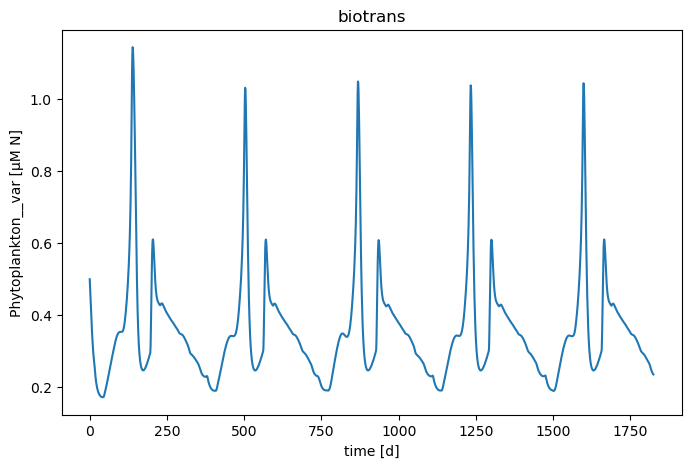

In [31]:
batch_out.sel(batch=0).Phytoplankton__var.plot()
plt.title(batch_out.sel(batch=0).Forcings__station.values)

# Let's test a more complex treatment of light in the model

We want to compare the simple Lambert Beer model for attenuation of light in the mixed layer, with the more complicated three layer model developed by Anderson et al. 1993.

In [32]:
from phydra.models.slabocean.fluxes.growth import EMPOWER_Smith_Anderson3Layer_ML

NPZDSlabOcean_3layer = NPZDSlabOcean.update_processes({'Light_lim':EMPOWER_Smith_Anderson3Layer_ML})

## Run the modified model across all stations:

Since all parameters and fluxes match across the two models, we can simply pass the new model object to the same model setup and execute the model:

In [33]:
from xsimlab.monitoring import ProgressBar

with ProgressBar():
    batch_out_3layer = batch_setup.xsimlab.run(batch_dim='batch', model=NPZDSlabOcean_3layer)

             0% | initialize 

             0% | initialize 

             0% | initialize 

             0% | initialize 

# A detailed comparitive plot of the two models for all four stations

In [34]:
# create a slice to extract the final year of the multi-year model run:
last_year_slice = slice((num_years -1) * 365, num_years * 365)
last_year_slice

slice(1460, 1825, None)

### Reading verification data

In [35]:
import pandas as pd

verifdata = pd.read_csv("data/stations_verification.csv", index_col=[0], header=[0,1])

### Plotting helper function

In [36]:
def modeloutputplot(i, dataset, verifdata, secondaryline=False):
    timedays_ly = dataset.time[0:365]
    
    N_Max = 30  
    P_Max = 2. 
    Z_Max = 1.5 
    D_Max = 1.5


    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15

    if not secondaryline:
        # Figure 1
        # N
        if i == 0:  
            ax1[i].annotate('Nutrients',xy=(0, 1),rotation=90,xytext=(-110,N_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[0])
            ax1[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

            ax2[i].annotate('Phytoplankton',xy=(0, 1),rotation=90,xytext=(-110,P_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[1])
            ax2[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

            ax3[i].annotate('Zooplankton',xy=(0, 1),rotation=90,xytext=(-110,Z_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[2])
            ax3[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

            ax4[i].annotate('Detritus',xy=(0, 1),rotation=90,xytext=(-110,D_Max/2), 
                            size='x-large', verticalalignment='center', c=culrNPZD[3])
            ax4[i].set_ylabel('[µM N]', multialignment='center', fontsize=12)

        ax1[i].set_ylim(0, N_Max)

        ax1[i].scatter(dpm_cumsum, verifdata.N.values, label='WOA data', c='grey')
        ax1[i].plot(timedays_ly, dataset.Nutrient__var[last_year_slice], c=culrNPZD[0], label='three layer')
        
        ChlConv = True
        # Phyto
        CtoChla = 75  # g/g
        MolarMassC = 12.0107
        CtoNratioPhyto = 6.625
        muMolartoChlaconvfactor = CtoChla / MolarMassC / CtoNratioPhyto  # Chla as mg/m-3 to

        ax2[i].scatter(dpm_cumsum, np.array(verifdata.Chla) * muMolartoChlaconvfactor, label='MODISaq data', c='grey')

        ax2[i].plot(timedays_ly, dataset.Phytoplankton__var[last_year_slice], c=culrNPZD[1],  label='three layer')
        ax2[i].set_ylim(0, P_Max)

        # Z
        ax3[i].plot(timedays_ly, dataset.Zooplankton__var[last_year_slice], c=culrNPZD[2], label='three layer')

        ax3[i].tick_params('y', labelsize=10)
        ax3[i].set_ylim(0, Z_Max)
        #ax4[i_plot].set_title('Zooplankton')

        # D
        ax4[i].plot(timedays_ly, dataset.Detritus__var[last_year_slice], c=culrNPZD[3], label='three layer')
        ax4[i].set_ylim(0,D_Max)
        ax4[i].set_xlabel('Time [days]')
        
        if i > 2:
            ax1[i].legend(fontsize='small')
            ax2[i].legend(fontsize='small')
            ax3[i].legend(fontsize='small')
            ax4[i].legend(fontsize='small')

        if i >= 1:
            ax1[i].set_yticklabels([])
            ax2[i].set_yticklabels([])
            ax3[i].set_yticklabels([])
            ax4[i].set_yticklabels([])
            
    else: 
        ax1[i].plot(timedays_ly, dataset.Nutrient__var[last_year_slice], 
                    linestyle='--', c=culrNPZD[0], label='single layer')
        
        ax2[i].plot(timedays_ly, dataset.Phytoplankton__var[last_year_slice], 
                    linestyle='--', c=culrNPZD[1],  label='single layer')
        
        ax3[i].plot(timedays_ly, dataset.Zooplankton__var[last_year_slice], 
                    linestyle='--', c=culrNPZD[2], label='single layer')
        
        ax4[i].plot(timedays_ly, dataset.Detritus__var[last_year_slice], 
                    linestyle='--', c=culrNPZD[3], label='single layer')
        
        if i > 2:
            ax1[i].legend(fontsize='small', loc='lower right')
            ax2[i].legend(fontsize='small')
            ax3[i].legend(fontsize='small')
            ax4[i].legend(fontsize='small')

### Create the plot

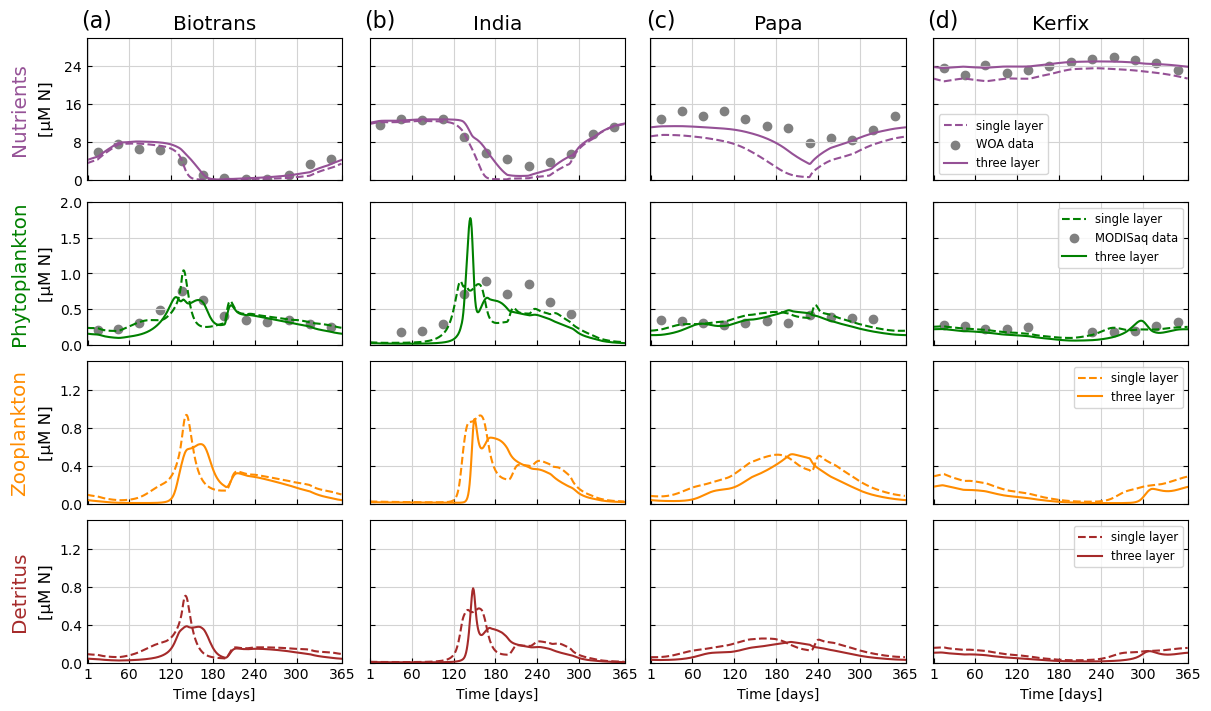

In [37]:
plt.rcParams['figure.figsize'] = [12, 7]

culrNPZD=['#955196','green','darkorange','brown']

numcols = 4
f1, (ax1, ax2, ax3, ax4) = plt.subplots(4, numcols, sharex='col', constrained_layout=True)

plt.setp((ax1, ax2, ax3, ax4), xticks=[1,60,120,180,240,300,365])
from matplotlib.ticker import MaxNLocator
for axe in (ax1, ax2, ax3, ax4):
    for i in range(numcols):
        axe[i].grid(True, color='lightgrey')
        axe[i].get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        axe[i].tick_params(top=False, right=True, direction="in")
        
modeloutputplot(0, batch_out.isel(batch=0), verifdata["biotrans"],  secondaryline=True)
modeloutputplot(0, batch_out_3layer.isel(batch=0), verifdata["biotrans"])

modeloutputplot(1, batch_out.isel(batch=1), verifdata["india"], secondaryline=True)
modeloutputplot(1, batch_out_3layer.isel(batch=1), verifdata["india"])

modeloutputplot(2, batch_out.isel(batch=2), verifdata["papa"], secondaryline=True)
modeloutputplot(2, batch_out_3layer.isel(batch=2), verifdata["papa"])

modeloutputplot(3, batch_out.isel(batch=3), verifdata["kerfix"], secondaryline=True)
modeloutputplot(3, batch_out_3layer.isel(batch=3), verifdata["kerfix"])

# ax1[muplot].invert_yaxis()

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365)

ax1[0].set_title('Biotrans', size='x-large')
ax1[1].set_title('India', size='x-large')
ax1[2].set_title('Papa', size='x-large')
ax1[3].set_title('Kerfix', size='x-large')


# Setting the values for all axes.
plt.setp((ax1, ax2, ax3), xlim=xlim)

f1.align_ylabels()

for i, label in enumerate(('(a)', '(b)', '(c)', '(d)')):
    ax1[i].text(0.1, 1.2, label, transform=ax1[i].transAxes,
      fontsize=16, fontweight='normal', va='top', ha='right')
    
#plt.savefig('02_EMPOWER_NPZDslab_lightcomp.pdf', bbox_inches='tight')